<a href="https://colab.research.google.com/github/seovalue/deep-learning-paper-study/blob/master/test/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
from keras.layers import Input,Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
drive.mount("/content/gdrive/")


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [11]:
IMAGE_SIZE=[299,299]
#폴더를 지정
train_path='/content/gdrive/My Drive/DL/인공지능교육/chest_xray/train/'
valid_path='/content/gdrive/My Drive/DL/인공지능교육/chest_xray/test/'

inception = InceptionV3(input_shape=IMAGE_SIZE+[3], weights='imagenet' ,include_top=False )
#인셉션v3 가장상단의 fully connected계층을 포함시키지 않음
# 반복문을 돌면서 레이어층을 읽어드림
for layer in inception.layers:
  layer.trainable=False 
#지정된 폴더에서 이미지를 모두 선택해줌
folders = glob(train_path+'*')
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

#컨볼루션 모델 학습
model = Model(inputs = inception.input , outputs = prediction)
model.summary()
model.compile( 
    loss='categorical_crossentropy',#현재 가중치 세트를 평가하는데 사용한 손실함수
    optimizer = 'adam', #최적의 가중치를 검색하는데 사용되는 최적화 알고리즘으로 
    #효율적인 경사 하강법 알고리즘
    metrics=['accuracy'] #평가 척도를 나타내며 분류문제에서는 
     #일반적으로 accuracy를 적용
)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [12]:
from keras.preprocessing.image import ImageDataGenerator
#이미지를 마음대로 바꾸면 곤란하니까 저희가 몇 가지 지시 사항을 줄 것
train_datagen = ImageDataGenerator(rescale = 1./255,  # 원본영상은 0-255의 RGB계수로 구성, input으로 모델을 효과적으로 학습시키는데 너무 높다.0-1범위로 변환시켜줌
                                   shear_range = 0.2, # 임의 전단 변화 범위
                                   zoom_range = 0.2, # 임의 확대/축소 범위
                                   horizontal_flip = True) # True설정할 경우 이미지를 수평으로 뒤집는다.원본 이미지에 수평 비대칭성이 없을 때 효과적


test_datagen = ImageDataGenerator(rescale = 1./255)
# flow_from_directory 폴더구조를 그대로 들고와서 ImageDataGenerator 객체의 실제 데이터를 채워줌
training_set = train_datagen.flow_from_directory(train_path, 
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical') #categorical 범주 분류 

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (299, 299),
                                            batch_size = 32, 
                                            class_mode = 'categorical')

r = model.fit_generator( training_set, validation_data=test_set, epochs=10,
                        steps_per_epoch=len(training_set),
                        validation_steps=len(test_set)
                        )

Found 2372 images belonging to 2 classes.
Found 619 images belonging to 2 classes.
Epoch 1/10
75/75 [==============================] - 2237s 30s/step - loss: 2.7684 - accuracy: 0.8874 - val_loss: 1.9372 - val_accuracy: 0.8756
Epoch 2/10
75/75 [==============================] - 88s 1s/step - loss: 1.0269 - accuracy: 0.9321 - val_loss: 5.4720 - val_accuracy: 0.7189
Epoch 3/10
75/75 [==============================] - 85s 1s/step - loss: 1.0698 - accuracy: 0.9368 - val_loss: 1.4691 - val_accuracy: 0.9144
Epoch 4/10
75/75 [==============================] - 82s 1s/step - loss: 0.5462 - accuracy: 0.9621 - val_loss: 1.3519 - val_accuracy: 0.9015
Epoch 5/10
75/75 [==============================] - 80s 1s/step - loss: 0.5900 - accuracy: 0.9591 - val_loss: 3.4681 - val_accuracy: 0.8756
Epoch 6/10
75/75 [==============================] - 80s 1s/step - loss: 0.6780 - accuracy: 0.9562 - val_loss: 1.7031 - val_accuracy: 0.9031
Epoch 7/10
75/75 [==============================] - 79s 1s/step - loss: 0.

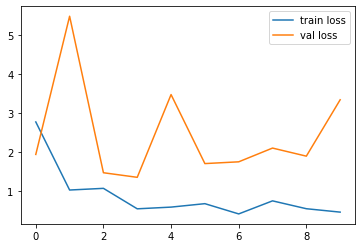

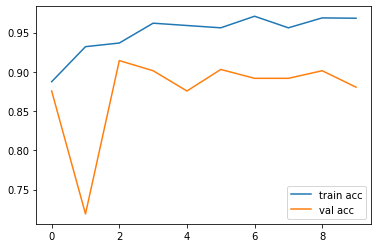

save model


<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#json 파일로 모델을 저장 , h5 파일로 모델에 적합한 가중치 저장 
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)
model.save_weights("model_vgg_16.h5")
print("save model")